<a href="https://colab.research.google.com/github/IrisFDTD/AI-UNIZAR-course/blob/main/ising_model/ai_unizar_course_ising_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Licencia Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">*Introducción a la inteligencia artificial: redes neuronales avanzadas con Tensorflow-Keras*</span> por <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Sergio Gutiérrez Rodrigo (sergut@unizar.es)</span> se distribuye bajo una <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Licencia Creative Commons Atribución-NoComercial-CompartirIgual 4.0 Internacional</a>.

```
Sergio G Rodrigo
Departamento de Física Aplicada
Universidad de Zaragoza
Instituto de Nanociencia y Materiales de Aragón (INMA)
C/ Pedro Cerbuna, 12, 50009, Zaragoza, España
```






# **Advanced Neural Networks with TensorFlow-Keras**

---
# **Application of CNNs to magnetism: 2D Ising model**
---


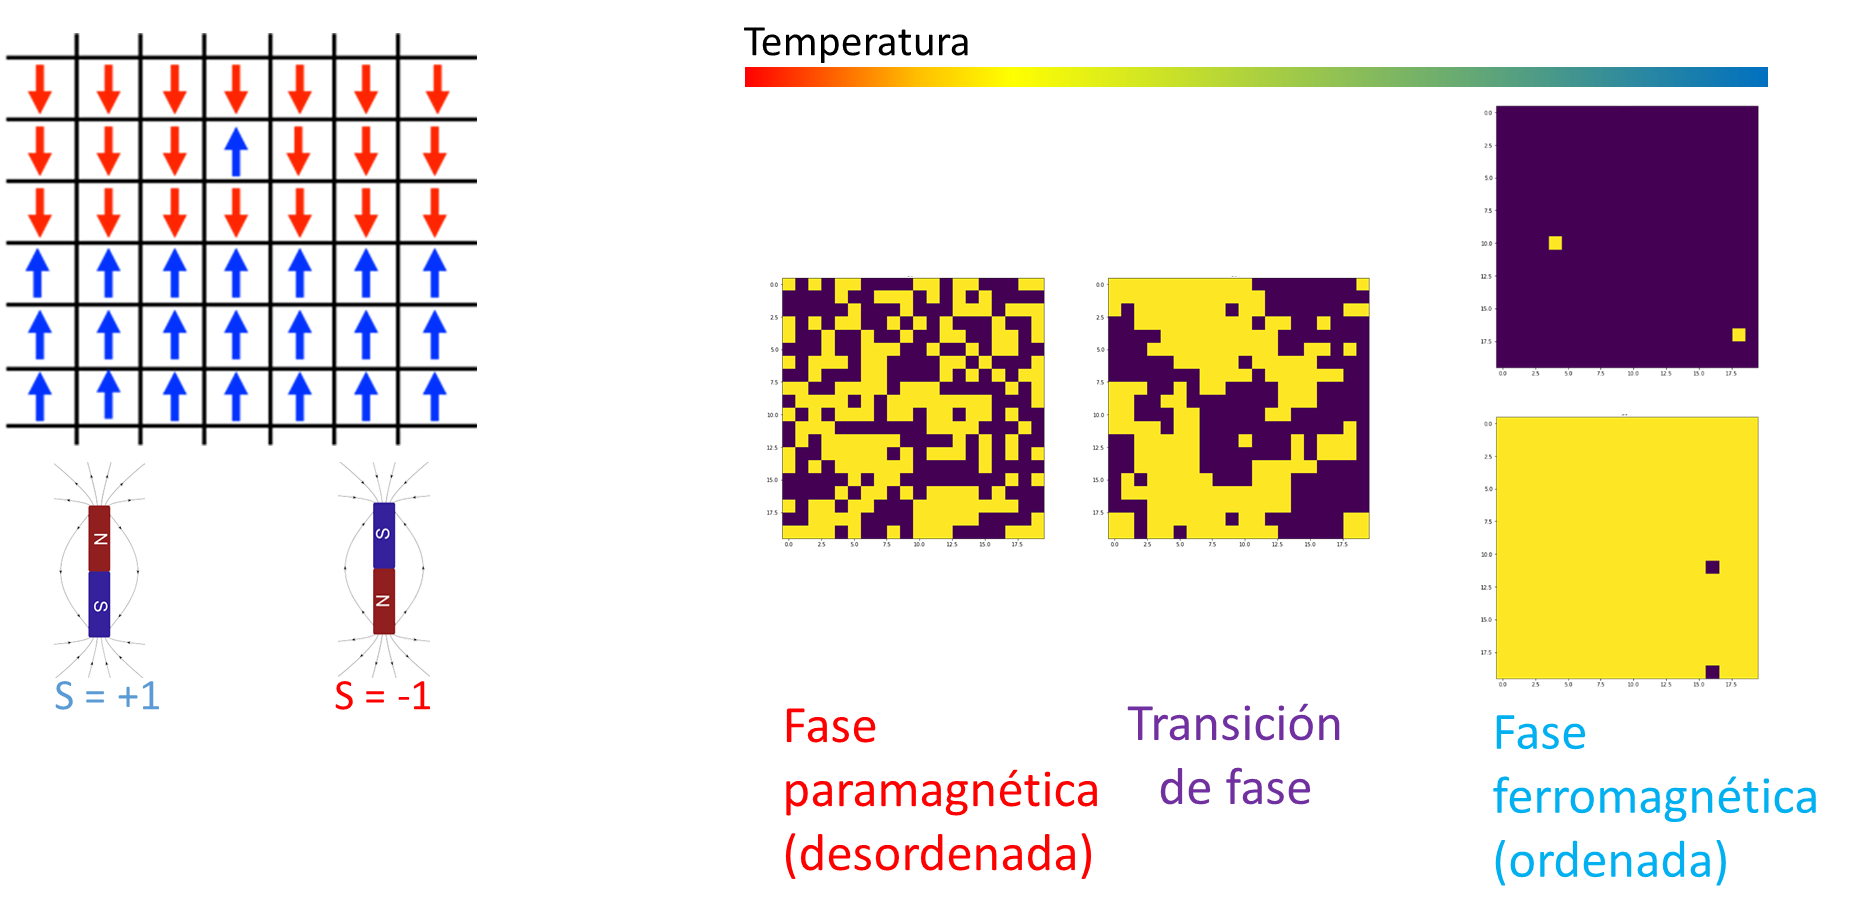

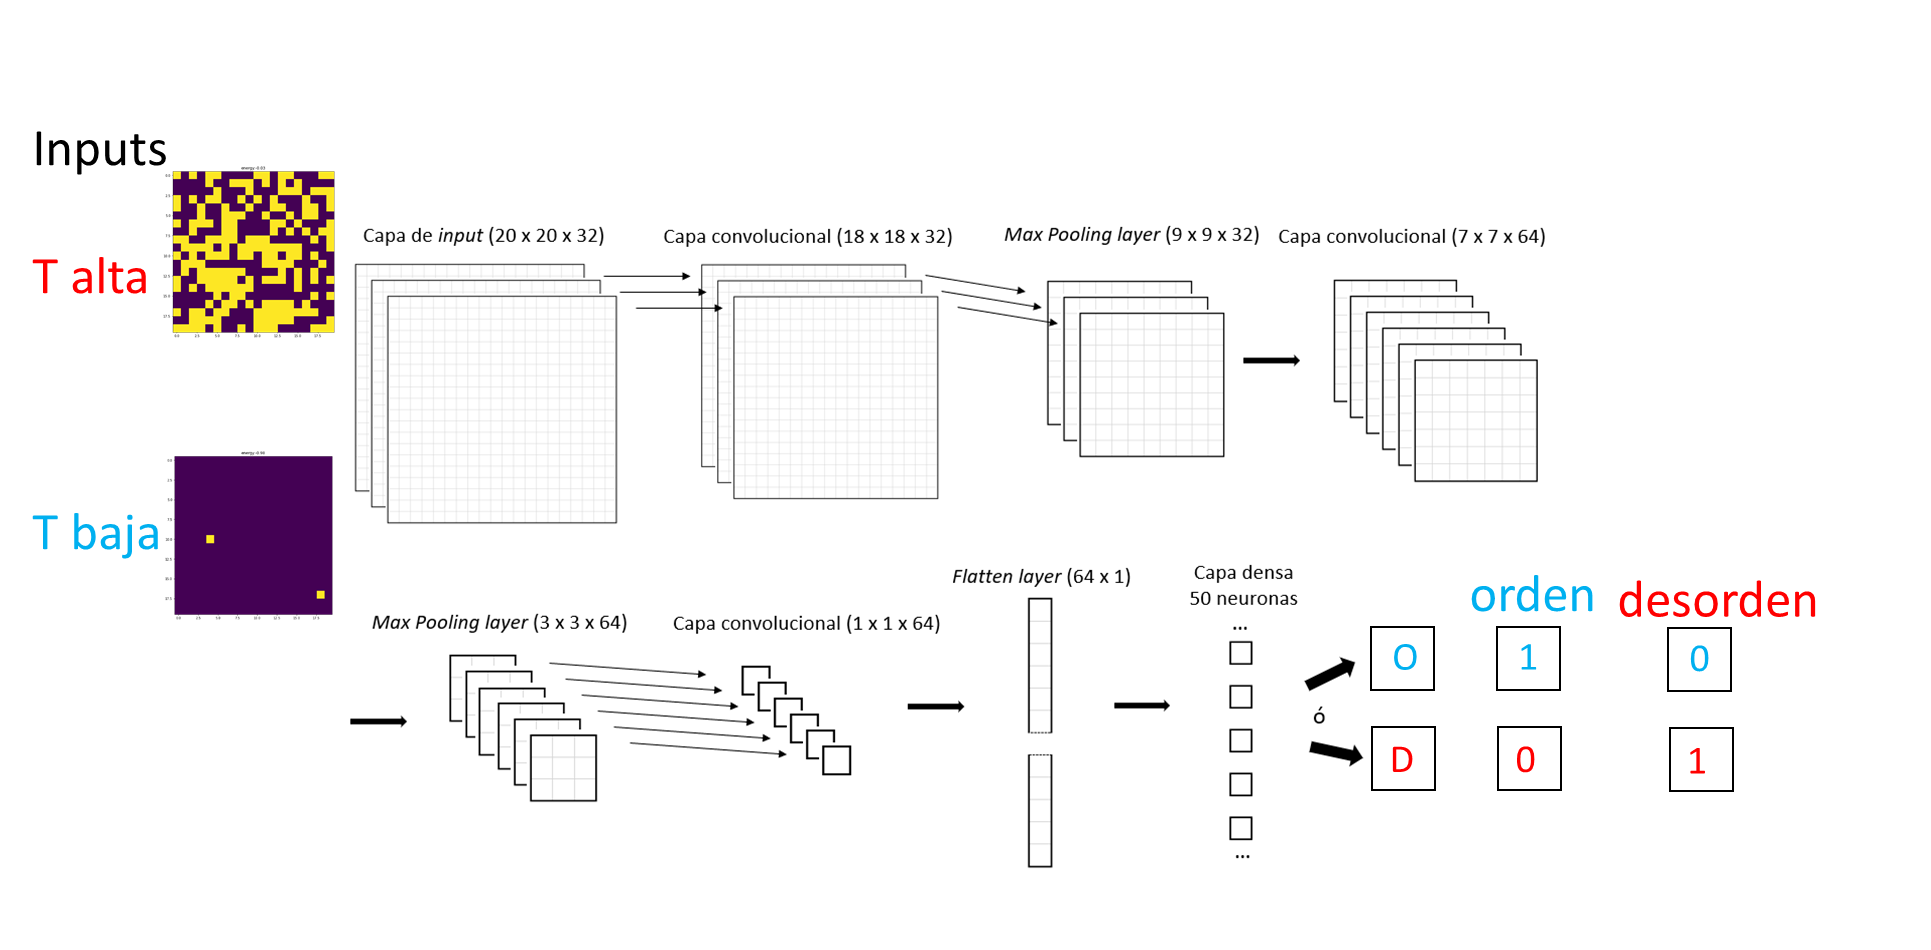

# Clone from Github

In [2]:
# Install Git (if not already installed)
!apt-get -q install git

# Replace placeholders with actual values
username = "IrisFDTD"
repository = "AI-UNIZAR-course"

# Clone the repository
repo_url = f"https://@github.com/{username}/{repository}.git"
!git clone {repo_url}

%cd {repository}
%cd ./ising_model/
%ls -lht

Reading package lists...
Building dependency tree...
Reading state information...
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Cloning into 'AI-UNIZAR-course'...
remote: Enumerating objects: 463, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 463 (delta 29), reused 28 (delta 17), pack-reused 407 (from 1)
Receiving objects: 100% (463/463), 91.95 MiB | 24.40 MiB/s, done.
Resolving deltas: 100% (234/234), done.
Updating files: 100% (15/15), done.
/content/AI-UNIZAR-course
/content/AI-UNIZAR-course/ising_model
total 68M
-rw-r--r-- 1 root root 440K Nov 11 11:25 temperatures.csv
-rw-r--r-- 1 root root  67M Nov 11 11:25 ising_configurations.csv
-rw-r--r-- 1 root root 630K Nov 11 11:25 ai_unizar_course_ising_model.ipynb


# Main imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

'''
Tensorflow libraries
'''
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,BatchNormalization

# Auxiliary functions


In [4]:
def show_ising_config(n, m, x, y,L):
    fig = plt.figure(figsize=(9, 13))
    columns = n
    rows = m
    ax = []
    for i in range(columns*rows):
        img = np.transpose(x[i,:].reshape([L,L]))
        # create subplot and append to ax
        ax.append( fig.add_subplot(rows, columns, i+1) )
        ax[-1].set_title("Beta="+str(y[i,0]))  # set title
        plt.imshow(img)
    plt.show()

def calc_energy(config):
    '''Energy of a given configuration'''
    energy = 0
    N=config.shape[0] # NxN Ising lattice
    for i in range(N):
        for j in range(N):
            S = config[i,j]
            nb = config[(i+1)%N, j] + config[i,(j+1)%N] + config[(i-1)%N, j] + config[i,(j-1)%N]
            energy += -nb*S
    return energy/4/N**2

def calcMag(config):
    '''Magnetization of a given configuration'''
    mag = np.sum(config)/len(config)**2
    return mag

In [5]:
def upload_file(filename):
  # Access the file
  df = pd.read_csv(filename, sep='\t')
  return df.to_numpy()

# Load Ising spin configurations and temperatures ($\beta$)


**File descriptions:**
+ $\beta \in [0,1]$.
+ $\Delta \beta=0.02$, so a total of 50 values of $\beta$.
+ 1000 configurations for each $\beta$.

In [6]:
file_config = 'ising_configurations.csv'
file_temp   = 'temperatures.csv'

In [7]:
# Read beta (temperatures)
ising_betas = upload_file(file_temp)
print("Temperature data set shape=",ising_betas.shape)

# Read spin configurations
ising_configs = upload_file(file_config)
print("Configuration data set shape=",ising_configs.shape)

# Describe datasets
nconfiguraciones = ising_configs.shape[0]
nspines = ising_configs.shape[1]
print('Number of configurations:', nconfiguraciones)
print('Total number of pixels (spin):', nspines)
print('Number of different temperatures:', np.unique(ising_betas))

Temperature data set shape= (49999, 1)
Configuration data set shape= (49999, 400)
Number of configurations: 49999
Total number of spins: 400
Number of different temperatures: [0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98]


# Training and test datasets

+ Training and validation $\beta \in [0, 0.37] \cup [0.5, 1]$
+ Test $\beta \in [0, 1]$

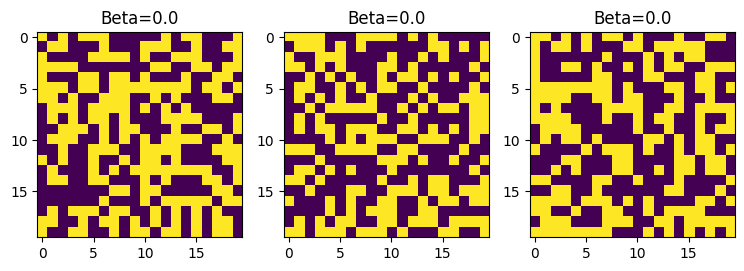



Ordered phase configurations= 24000
Random phase configurations= 18999


In [8]:
# Lattice size
L=int(np.sqrt(nspines))

# Number of labels (order,disorder)
nlabels = 2

# Excludes a range around beta_c
beta_low= ising_betas < 0.37
beta_high=ising_betas > 0.5

x_train = np.vstack((ising_configs[np.squeeze(beta_low)],
                     ising_configs[np.squeeze(beta_high)]))
y_train = np.vstack((ising_betas[np.squeeze(beta_low)],
                     ising_betas[np.squeeze(beta_high)]))

# Test ncludes the range around beta_c
x_test  = ising_configs
y_test  = ising_betas

# Before randomize configurations (only see beta=0 configurations)
show_ising_config(3, 1, x_train, y_train,L)

# Shuffle training data
nconfig_train=x_train.shape[0]
shuffle_list = np.random.permutation(range(nconfig_train))
x_train = x_train[shuffle_list, :]
y_train = y_train[shuffle_list,:]
print('\n')

# One hot encoding
'''
Beta <0.5 (high T) -> 0 ; Beta > 0.5 -> 1 (low T)
Neuron 0: 1 low T (ordered)
Neuron 1: 1 high T (disordered)
'''
def one_hot_encoding(y, nlabels):
    nimagenes = y.shape[0]
    y1h = np.zeros([nimagenes, nlabels])
    for image in range(nimagenes):
        if (y[image,0]>=0.5):
          # Low T
          y1h[image,0] = 1
          y1h[image,1] = 0
        else:
          # High T
          y1h[image,0] = 0
          y1h[image,1] = 1
    return y1h

y1h_train = one_hot_encoding(y_train, nlabels)

print("Ordered phase configurations=",np.count_nonzero(y1h_train[:,0] == 1.0))
print("Random phase configurations=",np.count_nonzero(y1h_train[:,0] == 0.0))

First 3 one hot encondings= 
 [[1. 0.]
 [1. 0.]
 [1. 0.]]


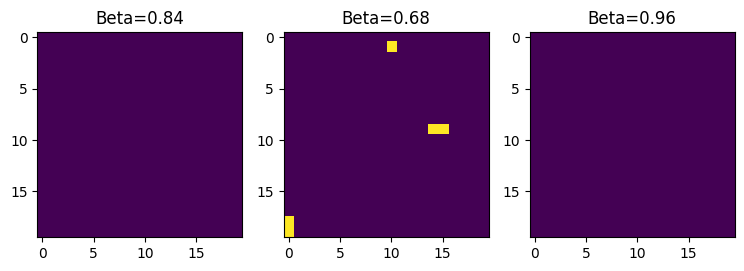

In [9]:
# After randomize configurations
print("First 3 one hot encondings= \n",y1h_train[0:3])
show_ising_config(3, 1, x_train, y_train,L)

# Run the model

In [10]:
neurons_in=x_train.shape[1]
epochs=10
mini_batch_size = 64
print("Neurons on the input layer =",neurons_in)

'''
Setup of Tensorflow model
'''
print(x_train.shape)
x_train=x_train.reshape((len(x_train),L,L,1))
print(x_train.shape)

img_cols=x_train.shape[1]
img_rows=x_train.shape[2]
input_shape = (img_cols,img_rows,1)

model = Sequential()
#----------------------------- CONV2D
model.add(Conv2D(32,
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
#------------------------------CONV2D
model.add(layers.Dense(50, activation='relu')) # new dense layer added
model.add(layers.Dense(nlabels, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

model.summary()

history=model.fit(x_train,y1h_train,
                  epochs=epochs,
                  batch_size=mini_batch_size,
                  verbose=1)

Neurons on the input layer = 400
(42999, 400)
(42999, 20, 20, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 18, 18, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 9, 9, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 1, 1, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           3,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,096 (230.84 KB)

 Trainable params: 59,096 (230.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9875 - loss: 0.0344
Epoch 2/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9995 - loss: 0.0019
Epoch 3/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 1.5476e-05
Epoch 4/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9992 - loss: 0.0024
Epoch 5/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 1.0000 - loss: 3.3887e-06
Epoch 6/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 1.3547e-06
Epoch 7/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 1.0382e-06
Epoch 8/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 1.0000 - loss: 6.6012e-07
Epoch 9/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 4.5921e-07
Epoch 10/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 4.7296e-07


## Summary of loss & accuracy

In [11]:
score = model.evaluate(x_train, y1h_train, verbose=0)
print('Loss:', score[0])
print('Accuracy:', score[1])

Loss: 2.67005077603244e-07
Accuracy: 1.0


dict_keys(['accuracy', 'loss'])


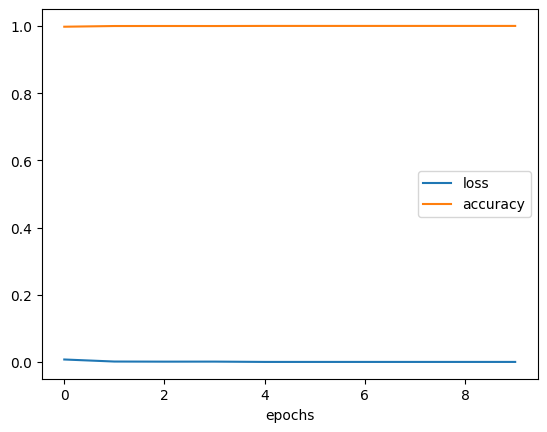

In [12]:
print(history.history.keys())
plt.plot(range(0,epochs),history.history['loss'],label='loss')
plt.plot(range(0,epochs),history.history['accuracy'],label='accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

# Predicting $\beta_c$



## Iterate through each beta value and calculate its mean

In [17]:
# Reshape x_test for conv2d input layer
x_test=x_test.reshape((len(x_test),L,L,1))
print("Input shape=",x_test.shape)

# Predictions on x_test
y_pred = model.predict(x_test)
print("Output shape=",y_pred.shape)

# Number of calculated betas and configurations per beta
# (fixed by the data set used for training)
Nbetas = 50
Nconfigsperbeta = 1000

# Averaged predictions on first and second output neurons (0 and 1)
predict0 = []
predict1 = []

# Iterate through each beta value and calculate its mean
for i in range(Nbetas):
  aux_matrix = y_pred[i*Nconfigsperbeta:(i+1)*Nconfigsperbeta-1]
  aux1 = np.mean(aux_matrix[:,0])
  aux2 = np.mean(aux_matrix[:,1])
  predict0.append([aux1]) # Neuron #0
  predict1.append([aux2]) # Neuron #1

# Convert to numpy arrays
predict0=np.array(predict0)
predict1=np.array(predict1)

Input shape= (49999, 20, 20, 1)
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Output shape= (49999, 2)


## Plot output neurons vs $\beta$

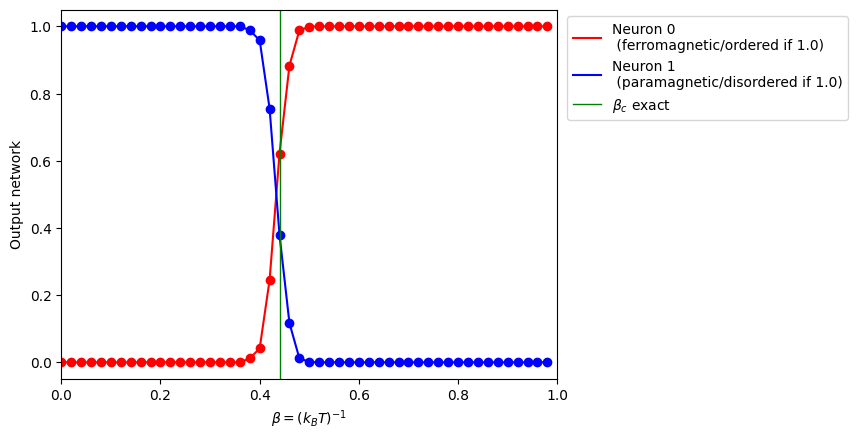

In [14]:
# Numerical beta_c
beta_c=0.4406
x_beta=np.unique(y_test)

# Plot the results
plt.scatter(x_beta, predict0, c='r')
plt.scatter(x_beta, predict1, c='b')
plt.plot(x_beta, predict0, c='r', label = 'Neuron 0 \n (ferromagnetic/ordered if 1.0)')
plt.plot(x_beta, predict1, c='b', label = 'Neuron 1 \n (paramagnetic/disordered if 1.0)')
plt.xlabel(r'$\beta=(k_B T)^{-1}$')
plt.ylabel("Output network")
plt.axvline(x=beta_c, linewidth=1, color='g', label = r'$\beta_c$ exact')
plt.legend(loc='upper right', bbox_to_anchor=(1.6, 1.0))
plt.xlim(0.0, 1.0)
plt.show()

# Appendix: Ising model theory

The Ising model originates from the study of magnetic materials and aims to reproduce the essential qualitative properties of some of these materials. One of the main properties of these materials is the existence of a phase transition at a certain temperature, which separates two different behaviors of the material. Above this temperature, referred to as the "critical temperature" or "Curie temperature," magnetic materials are in a paramagnetic state where electron spins are randomly oriented. As the temperature decreases, these spins begin to align, forming groups with the same orientation, leading to different magnetic domains. Below the Curie temperature, magnetic materials exhibit spontaneous magnetization, causing the mentioned domains to grow larger until all spins achieve the same orientation.

In this work, we will consider the two-dimensional Ising model with nearest-neighbor interactions. Only two possible spin orientations are considered: spin up and spin down. The model's arrangement will be a grid of spins with dimensions $L \times L$, where each of the $L^2 = V$ spins can take two values:

$S = \begin{cases}
+1 & \text{if the spin is up} \\
-1 & \text{if the spin is down}
\end{cases}$

The system's Hamiltonian is given by the following expression:
$H = -J \sum_{\langle i, j \rangle} S_i S_j - H \sum_{i=1}^V S_i \quad (1)$

Here, $J$ is a constant representing ferromagnetic interaction strength. It can be factored out of the sum due to nearest-neighbor interactions (on a square lattice, a spin only interacts with its top, bottom, right, and left neighbors) and equal magnitudes for all pairs. Additionally, the sign of $J$ determines the magnetic properties of the material: if $J$ is positive, the material exhibits ferromagnetic behavior, while if it's negative, the behavior is antiferromagnetic. The first summation is taken over all possible pairs of spins $\langle i, j \rangle$, and $H$ represents an external magnetic field.

In the absence of an external magnetic field, which is the case we'll consider, we can omit the second term of Equation (1).

Each set of $L \times L$ spins is referred to as a configuration. There are many possible different configurations of the 2D Ising network, but some are more likely to appear than others. Let's consider a specific configuration $C_\alpha$. The probability of encountering this configuration depends on its energy and temperature and is given by:

$p(C_\alpha) = \frac{1}{Z(\beta)} e^{-\beta H(C_\alpha)} \quad (2)$

Here, we've defined $\beta = (k_B T)^{-1}$, where $k_B$ is the Boltzmann constant, taken to be 1 throughout this work. $Z$ is the partition function, defined as per Equation (11), where the summation spans all possible configurations:

$Z(\beta) = \frac{1}{\sum_C e^{-\beta H(C_\alpha)}} \quad (11)$

In addition to energy, another relevant quantity for configurations is magnetization. We mentioned earlier that during a phase transition, below the Curie temperature, spontaneous magnetization appears. Its significance stems from being the order parameter in the transition. Magnetization and its intensive magnitude can be defined as follows:

$M = \sum_j S_j \quad \text{and} \quad m = \frac{1}{V} \sum_j S_j \quad (3)$

In other words, magnetization is the sum of all spins. Considering that in the paramagnetic state, spins have random orientations, the expected value of magnetization is 0. However, in the ferromagnetic state, all spins align to create an ordered configuration, and the intensive magnetization is expected to have a value of +1 or -1, depending on the preferred orientation direction of the spins: up or down.